# Titanic prediction - top 8 %


## Define useful global functions

Collecting global functions to be used throughout here. 

In [1]:
# Send in a list of tuples
def table_R(df):
    x = [tuple(x) for x in df.values]
    ps = pd.Series([tuple(i) for i in x])
    print(ps.value_counts())

def create_submission(test, preds_test, file_name):
    submission = pd.concat([test_orig['PassengerId'], pd.Series(preds_test).astype("int")], axis=1)
    submission.columns = ['PassengerId', 'Survived']
    submission.head()
    submission.to_csv(file_name, index = False)

# Returns a fitted and tuned model. Will also create predictions. 
def run_model(train, test, cv_grid_params,file_name = "submission.csv", regression = False, gauss_proc = False):
    from sklearn.model_selection import cross_val_score, GridSearchCV
    from sklearn.metrics import confusion_matrix
    
    X_train = train.drop(['Survived'], axis = 1)
    y_train = train['Survived']
    X_test = test.drop(['Survived'], axis = 1)
    y_test = test['Survived']

    grid_search = GridSearchCV(**cv_grid_params)
    grid_search.fit(X_train,y_train)
    
    model = cv_grid_params['estimator']
    
    model.set_params(**grid_search.best_params_)
    model.fit(X_train,y_train)
    cv_scores = cross_val_score(model, X_train, y_train, cv = 10)
    print("Cross validation scores:" + str(cv_scores))
    print("Mean score: " + str(cv_scores.mean()))
    test_preds = model.predict(X_test)
    if regression == False:
        print("Train confusion matrix:" )
        print(confusion_matrix(y_train.astype("int"), model.predict(X_train).astype("int")))
        print("Predicting and creating submission. ")
        create_submission(X_test, test_preds.astype("float"), file_name)
    else:
        train_preds = model.predict(X_train)
        
        preds_test = []
        preds_train = []
        for i in range(train_preds.shape[0]):
            if train_preds[i] < 0.5:
                preds_train.append(0)
            else:
                preds_train.append(1)
        print("Train confusion matrix:" )
        print(confusion_matrix(y_train, np.array(preds_train)))
        for i in range(test_preds.shape[0]):
            if test_preds[i] < 0.5:
                preds_test.append(0)
            else:
                preds_test.append(1)
        print("Predicting and creating submission. ")
        create_submission(X_test, model.predict(X_test).astype("float"), file_name)
    
    return test_preds, model
        
    

## Start with processing data, feature fixing etc. 

In [2]:
import numpy as np
import pandas as pd

# Set seed to always be used
seed = 123

train_orig = pd.read_csv("train.csv")
test_orig = pd.read_csv("test.csv")
data = pd.concat([test_orig,train_orig], sort = False)
data = data.reset_index()

class_weights = {
    0: (train_orig['Survived'] == 0).sum()/train_orig.shape[0],
    1: (train_orig['Survived'] == 1).sum()/train_orig.shape[0]
}

data.describe()

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


,index,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
count,1309.000000,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,891.000000
mean,369.478992,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479,0.383838
std,248.767105,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668,0.486592
min,0.000000,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,327.000000,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,563.000000,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,890.000000,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


### Check for null values

Okay, so we need to fix age, Fare, Cabin and Embarked. Survived's null values is the test set. 

In [3]:
data.isna().sum()

index             0
PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Survived        418
dtype: int64

In [4]:
# Fill the missing one. 
data['Fare'] = data['Fare'].fillna(data['Fare'].dropna().median())

## Fixing Cabin department out of Cabin feature

We can get which department people lived, as well as their enumeration. The most probable is that the letter accounted for different sections, 

In [5]:
print(data['Cabin'].isnull().sum())
data['Cabin_dep'] = [cabin_no[0] for cabin_no in data['Cabin'].astype("str")]
data['Cabin_dep'] = data['Cabin_dep'].astype("category")

1014


## Fixing age variable

As we saw, we have many ages that are NaN. To compensate for this, we simulate the distribution and obtain new samples. Make sure to use seed.  

We sample for the training set and test set individually. For the test set, we just sample out of the distribution it has. For the training and test set, we sample out of densities for each class. 

The test distribution is, as seen, similar to the ones who died, which *might* indicate that we will rather have more people dying in the test set. 

In [6]:
from matplotlib.pyplot import hist
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde
hist(data['Age'].dropna(), density = True)
from scipy.stats import poisson

dens0 = gaussian_kde(data.Age[data['Survived'] == 0].dropna())
dens1 = gaussian_kde(data.Age[data['Survived'] == 1].dropna())
densNA = gaussian_kde(data.Age[data['Survived'].isna()].dropna())

x0 = np.arange(0,data.Age[data['Survived'] == 0].dropna().max())
x1 = np.arange(0,data.Age[data['Survived'] == 1].dropna().max())
xNA = np.arange(0,data.Age[data['Survived'].isna()].dropna().max())

plt.plot(x0, dens0.evaluate(x0), 'r')
plt.plot(x1, dens1.evaluate(x1), 'g')
plt.plot(xNA, densNA.evaluate(xNA), 'b')
plt.legend(["Died", "Survived", "Test dist"])
plt.title("Density slightly different, but not very. Still worth to separate sampling though. ")

dist0 = dens0.evaluate(x0)
# Normalize
dist0 = np.divide(dist0,np.sum(dist0))
dist0 = dens0.evaluate(x0)
# Normalize
dist0 = np.divide(dist0,np.sum(dist0))

dist1 = dens1.evaluate(x1)
# Normalize
dist1 = np.divide(dist1,np.sum(dist1))
dist1 = dens1.evaluate(x1)
# Normalize
dist1 = np.divide(dist1,np.sum(dist1))

distNA = densNA.evaluate(xNA)
# Normalize
distNA = np.divide(distNA,np.sum(distNA))
distNA = dens1.evaluate(xNA)
# Normalize
distNA = np.divide(distNA,np.sum(distNA))


# We should sample out of this distribution to compensate. 
np.random.seed(seed)
nan_ages0 = np.random.choice(x0, p = dist0, size = data['Age'].isnull().sum())
nan_ages1 = np.random.choice(x1, p = dist1, size = data['Age'].isnull().sum())
nan_agesNA = np.random.choice(xNA, p = distNA, size = data['Age'].isnull().sum())

count = 0
for i in list(data.Age[data['Survived'] == 0].index[np.where(data.Age[data['Survived'] == 0].isna())]):
    data['Age'][i] = nan_ages0[count]
    count += 1
        
count = 0
for i in list(data.Age[data['Survived'] == 1].index[np.where(data.Age[data['Survived'] == 1].isna())]):
    data['Age'][i] = nan_ages1[count]
    count += 1

count = 0
for i in list(data.Age[data['Survived'].isna()].index[np.where(data.Age[data['Survived'].isna()].isna())]):
    data['Age'][i] = nan_agesNA[count]
    count += 1

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Remove outliers 

First of all, I discovered while doing the things below, that there are many outliers in the dataset. To do this, I use the Z-score as in [this article from Towards Data Science](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba). This is only done on the numerical features. 

A critique towards this is that we assume a normal distribution of these, which might be far from the case. However, we'll do it, and see if it works well. 

In [7]:
from scipy.stats import zscore

indices_age = data.Age[data['Age'].isnull() == False].index
z_scores_age = np.abs(zscore(data.Age[data['Age'].isnull() == False]))


z_scores = pd.DataFrame(columns=['Age','SibSp','Parch','Fare'])
z_scores['SibSp'] = zscore(data.SibSp)
z_scores['Parch'] = zscore(data.Parch)
z_scores['Fare'] = zscore(data.Fare)
z_scores['Age'] = zscore(data.Age)
    
outlier_rows, outlier_cols = np.where(z_scores > 3)

outliers = {}

for i,col in enumerate(outlier_rows):
    if outlier_rows[i] not in outliers:
        outliers[outlier_rows[i]] = [outlier_cols[i]]
    else:
        outliers[outlier_rows[i]].append(outlier_cols[i])

        
# Remove all being outlier in 2 or more columns
to_del = []
for outlier in outliers:
    if len(outliers[outlier]) >= 2 and outlier <= 891:
        to_del.append(outlier)

# Now delete all in list to_del

for i in to_del:
    data.drop(data.index[i], inplace=True)

Okay, we only removed 4. Hopefully this will help the model. 

In [8]:
data.isnull().sum()

index             0
PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1011
Embarked          2
Survived        415
Cabin_dep         0
dtype: int64

### Sex variable

The sex feature does not have any null values. However, we clearly see that men died to a much larger extent than women. Women clearly seem to have been prioritised. 

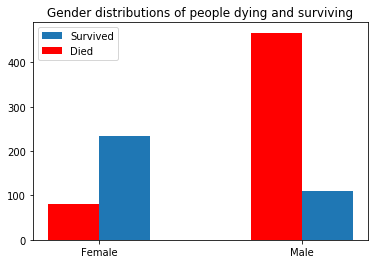

In [9]:
data['Sex'].isnull().sum()
data['Sex'] = data['Sex'].astype('str')
data['Sex'] = data['Sex'].replace({'male':1, 'female':-1})
x=np.arange(1,4,2)
plt.bar(x, data.Sex[data['Survived'] == 1].value_counts().sort_index(), width = 0.5)
plt.title("Gender distributions of people dying and surviving")
plt.xticks(x - 0.25,["Female", "Male"])
plt.bar(x-0.5, data.Sex[data['Survived'] == 0].value_counts().sort_index(), width = 0.5, color = "r")
plt.legend(["Survived","Died"])

### Fare variable

What can be seen with the fare variable? 

There is one missing, in the test set. Just replace this one with the mean to compensate for it. 

Survived: Mean: 48.39540760233918, sd: 66.49956280917583
Died: Mean: 22.140912226277372, sd: 31.383569712357126


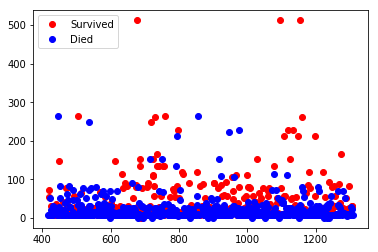

In [10]:
plt.plot(data.Fare[data['Survived'] == 1], 'ro')
plt.plot(data.Fare[data['Survived'] == 0], 'bo')
plt.legend(["Survived", "Died"])
print("Survived: Mean: "+str(np.mean(data.Fare[data['Survived'] == 1]))+ ", sd: " + str(np.std(data.Fare[data['Survived'] == 1])))
print("Died: Mean: "+str(np.mean(data.Fare[data['Survived'] == 0]))+ ", sd: " + str(np.std(data.Fare[data['Survived'] == 0])))

### Parch feature

The parch feature apparently indicates how many parents and children aboard the passenger in question had. This variable might give a good indication - a person with no family probably did not have to collect any family members. It is also quite probable that big, poor families were travelling. 

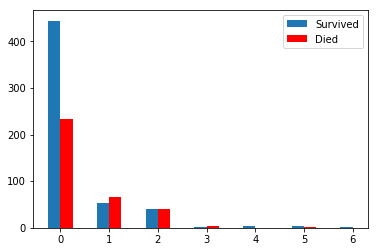

In [11]:
x = np.arange(0,14,2)
plt.bar(x - 0.25, data.Parch[data['Survived'] == 0].value_counts().sort_index(), width = 0.5)
plt.bar(2*data.Parch[data['Survived'] == 1].value_counts().sort_index().index + 0.25, data.Parch[data['Survived'] == 1].value_counts().sort_index(), color = 'r', width = 0.5)
plt.xticks(x,np.arange(0,7,1))
plt.legend(['Survived', 'Died'])
plt.show()

Let's reduce the variance on this, and let 3 be "3+", as these indicate outliers. Also, we only have 2 that have the value 6, which is weird. This probably gives a better, more general model input. 

0    999
1    170
2    113
3     23
Name: Parch, dtype: int64


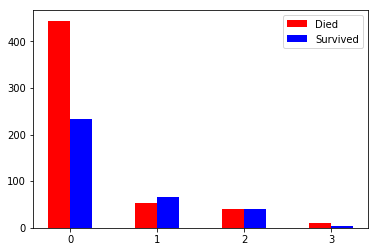

In [12]:
data.loc[data['Parch'] >= 3, 'Parch'] = 3
print(data.Parch.value_counts().sort_index())
x = np.arange(0,8,2)
plt.bar(x - 0.25, data.Parch[data['Survived'] == 0].value_counts().sort_index(), width = 0.5, color = "r")
plt.bar(2*data.Parch[data['Survived'] == 1].value_counts().sort_index().index + 0.25, data.Parch[data['Survived'] == 1].value_counts().sort_index(), color = 'b', width = 0.5)
plt.xticks(x,np.arange(0,7,1))
plt.legend(['Died', 'Survived'])

### SibSp feature

The SibSp indicates how many siblings and spouses the person had onboard. Again, this probably indicates whether they had to go back for someone or not. 



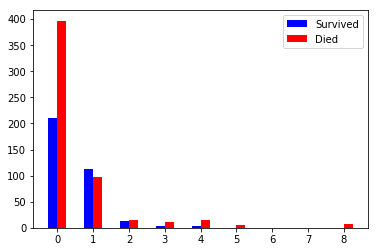

In [13]:
x = np.array([0,1,2,3,4,5,8])

plt.bar(np.array([0,2,4,6,8]) - 0.25,data.SibSp[data['Survived'] == 1].value_counts().sort_index(), color="b", width=0.5)
plt.bar(2*np.array([0,1,2,3,4,5,8]) + 0.25,data.SibSp[data['Survived'] == 0].value_counts().sort_index(), color = "r", width=0.5)
plt.legend(["Survived", "Died"])
plt.xticks(np.arange(0,18,2),np.arange(0,9))
plt.show()

We have clear outliers. I think we will do 4+ on this one. 

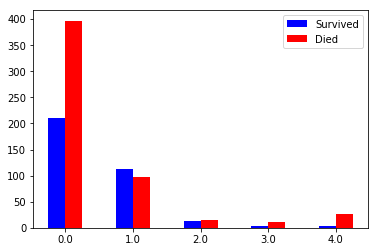

In [14]:
data.loc[data['SibSp'] >= 4, 'SibSp'] = 4

x = np.arange(0,10,2)

plt.bar(x - 0.25,data.SibSp[data['Survived'] == 1].value_counts().sort_index(),width=0.5, color="b")
plt.bar(x + 0.25,data.SibSp[data['Survived'] == 0].value_counts().sort_index(),width=0.5, color="r")
plt.legend(['Survived', 'Died'])
plt.xticks(x,x/2)
plt.show()

### Name feature

The name feature is interesting, from which we can draw some other features perhaps. 

In [15]:
data.Name.head()

0                                Kelly, Mr. James
1                Wilkes, Mrs. James (Ellen Needs)
2                       Myles, Mr. Thomas Francis
3                                Wirz, Mr. Albert
4    Hirvonen, Mrs. Alexander (Helga E Lindqvist)
Name: Name, dtype: object

It seems like many has titles in their names. 

#### Create Title feature

First of all, everyone seems to have a title "Mr.", "Mrs.", "Master." or "Miss.". Thus, we create a new one with their title. 

<input>:5: DeprecationWarning: invalid escape sequence \w
<ipython-input-16-df4952e61902>:5: DeprecationWarning: invalid escape sequence \w
  matches = re.findall("\w+\.",name)


Mr.         758
Miss.       264
Mrs.        199
Master.      61
Rev.          8
Dr.           8
Military      7
Name: Title, dtype: int64


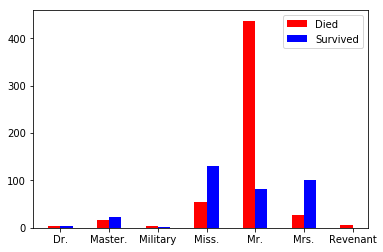

In [16]:
#print(['yes' for x in [x.lower() for x in list(data['Name'].values)] if 'master' in x])
def create_title(name_col):
    import re
    for name in name_col:
        matches = re.findall("\w+\.",name)
        yield matches[0]

data['Title'] = list(create_title(data['Name']))
#print(data['Title'].value_counts())
data['Title'] = data['Title'].replace({'Mlle.':'Miss.','Ms.':'Miss.','Jonkheer.':"Mr.","Major.":"Mr.","Countess.":"Mrs.","Don.":"Mr.", "Dona.":"Mrs.","Sir.":"Mr.","Mme.":"Miss.", "Col.":"Military", "Major.":"Military","Capt.":"Military", "Lady.":"Mrs."})
print(data['Title'].value_counts())

x = np.arange(0,14,2)

plt.bar(x - 0.25, data.Title[data['Survived'] == 0].value_counts().sort_index(), color = "r", width = 0.5)
plt.bar(x[:6] + 0.25, data.Title[data['Survived'] == 1].value_counts().sort_index(), color = "b", width = 0.5)
plt.xticks(x,["Dr.", "Master.", "Military","Miss.","Mr.","Mrs.","Revenant"])
plt.legend(["Died","Survived"])
plt.show()


Interesting is that *all* the revenants died. **Military** is a collection of military title. I did find many noble title, and that might have been interesting to separate. 

## Ticket feature
Let us look at the ticket feature. 

Tickets seem to be a number or with letters and a number, indicating some sort of special ticket. Let's categorize them into into "Numbered" and their letters. Since we have so many different types, I will just base them based on the first letter. 

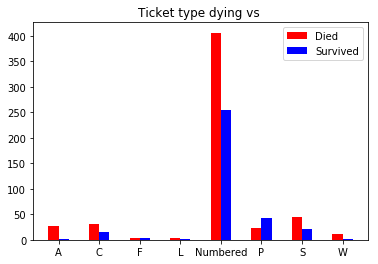

In [17]:
data.Ticket.head(20)
data.Ticket.loc[20]

ticket_type = []

import re

#print(data.Ticket)
for ticket in data.Ticket.values:
    if ticket.isdigit():
        ticket_type.append("Numbered")
    else:
        ticket_type.append([re.sub('[^a-zA-Z_]','', x)[0:1] for x in ticket.split(" ")][0])
        
data['Ticket_type'] = ticket_type
x = np.arange(0,16,2)
plt.bar(x - 0.25,data.Ticket_type[data['Survived'] == 0].value_counts().sort_index(), color = "r", width = 0.5)
plt.bar(x + 0.25, data.Ticket_type[data['Survived'] == 1].value_counts().sort_index(), color = "b", width = 0.5)
plt.legend(['Died', 'Survived'])
plt.title("Ticket type dying vs ")
plt.xticks(x,data.Ticket_type[data['Survived'] == 0].value_counts().sort_index().index)
plt.show()

There actually does seem to be some kind of useful information here. P seems to have survived to larger extent. However, the other seem to, unfortunately, follow the same distribution as the whole training set more or less. 

### Fix dummy variables for categories that we that

In [18]:
data = pd.get_dummies(data.drop(['Cabin','Ticket','Name'], axis = 1))
data.head()

,index,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Survived,Embarked_C,...,Title_Mrs.,Title_Rev.,Ticket_type_A,Ticket_type_C,Ticket_type_F,Ticket_type_L,Ticket_type_Numbered,Ticket_type_P,Ticket_type_S,Ticket_type_W
0,0,892,3,1,34.5,0,0,7.8292,NaN,0,...,0,0,0,0,0,0,1,0,0,0
1,1,893,3,-1,47.0,1,0,7.0000,NaN,0,...,1,0,0,0,0,0,1,0,0,0
2,2,894,2,1,62.0,0,0,9.6875,NaN,0,...,0,0,0,0,0,0,1,0,0,0
3,3,895,3,1,27.0,0,0,8.6625,NaN,0,...,0,0,0,0,0,0,1,0,0,0
4,4,896,3,-1,22.0,1,1,12.2875,NaN,0,...,1,0,0,0,0,0,1,0,0,0


### Split into training and test set

We should also upsample to balance the class weights. This does however make the training set's confusion matrix not necessarily representative. 

It can be done with upsampling, which was tried. However, I will use the class weights for those models where this is available instead, to induce a loss function. 

In [19]:
train, test = [x for _, x in data.groupby(data['Survived'].isnull())]
train = train.drop(['index', 'PassengerId'], axis = 1)
test = test.drop(['index', 'PassengerId'], axis = 1)
"""
# The upsampling, which later was chosen not to use. 
n_dying = train[train['Survived'] == 0].shape[0]
n_surviving = train[train['Survived'] == 1].shape[0]
n_to_sample = n_dying - n_surviving
print("Resampling "+str(n_to_sample)+" samples from training set. ")

resamples = train[train['Survived'] == 1].sample(n_to_sample, axis = 0)

train = pd.concat([train, resamples])"""

train.Survived.value_counts()

0.0    548
1.0    342
Name: Survived, dtype: int64

## Data processing done - time for modelling

First off, we simply try a ridge regression with an rbf kernel and see its performance. This is kind of unchristly as it is actually regression, but it might actually perform well. 

In [20]:
X_train = train.drop(['Survived'], axis = 1)
y_train = train['Survived']
X_test = test.drop(['Survived'], axis = 1)

## Ridge kernel regression

Ridge kernel regression might give a nice result. Although it is not classification, this has interestingly worked well before. 

In [21]:
from sklearn.kernel_ridge import KernelRidge

kern_ridge = KernelRidge()

params = {'alpha': [0.01,0.1, 1.0],
 'coef0': [0,0.1,1],
 'degree': [1,2,3],
 'gamma': [0.01,1,10],
 'kernel': ['rbf']
}

grid_params = {
    'estimator':kern_ridge,
    'param_grid':params,
    'n_jobs':2,
    'iid':False,
    'verbose':True,
    'scoring':'neg_mean_squared_error',
    'cv':10
}

y_preds_ridge, ridge_model = run_model(train, test, grid_params, file_name = "submission_ridge.csv", regression = True)

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  55 tasks      | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done 355 tasks      | elapsed:   22.1s
[Parallel(n_jobs=2)]: Done 807 out of 810 | elapsed:   51.5s remaining:    0.2s
[Parallel(n_jobs=2)]: Done 810 out of 810 | elapsed:   51.6s finished


Cross validation scores:[0.23246905 0.09875768 0.2177755  0.06730786 0.32686489 0.38294204
 0.29414995 0.22166722 0.36592025 0.44932722]
Mean score: 0.26571816737629483
Train confusion matrix:
[[514  34]
 [ 49 293]]
Predicting and creating submission. 


## Logistic regression

Now lets try logistic regression. 

In [23]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression()

log_reg_params = {'C': [0.1,1.0,10,100], 
                  'class_weight': [None], 
                  'dual': [None], 
                  'fit_intercept': [True,False], 
                  'max_iter': [10000], 
                  'multi_class': ['ovr'],
                  'class_weight':[class_weights],
                  'n_jobs': [1],
                  'penalty': ['l1','l2'],
                  'random_state': [123],  
                  'tol': [0.0001, 0.0005,0.001], 
                  'solver':['saga'],
                  'warm_start': [False]}
grid_params['estimator'] = log_reg_model
grid_params['param_grid'] = log_reg_params
grid_params['scoring'] = 'accuracy'

test_preds_log_reg, log_reg_model = run_model(train, test, grid_params, file_name = "submission_log_reg.csv")

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   23.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 480 out of 480 | elapsed:  3.6min finished


Cross validation scores:[0.77777778 0.76666667 0.7752809  0.83146067 0.7752809  0.76404494
 0.80898876 0.76404494 0.84090909 0.79545455]
Mean score: 0.7899909204403587
Train confusion matrix:
[[497  51]
 [120 222]]
Predicting and creating submission. 


So Logistic regression performed worse. Let's choose the Ridge Regression for the classification. 

### XGBoost 

Let's try XGBoost instead. The score, without tuning hyperparameters or any cross-validation, resulted in 0.77, quite a good score. 

#### Tuning the parameters of XGBoost

Let's tune the parameters for XGBoost and see how well it performs. 

In [24]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()

params_xgb = {
    'base_score':[0.3,0.5],
    'colsample_bytree':[0.4,0.7],
    'gamma':[0.01,0.5,0.9],
    'min_child_weight':[1,3],
    'learning_rate':[0.01,0.1,1],
    'max_depth':[3,4,5],
    'n_estimators':[500],
    'reg_alpha':[1e-5, 0.1],
    'reg_lambda':[1e-5, 0.1],
    'subsample':[0.8]
}

grid_params['estimator'] = xgb_model
grid_params['param_grid'] = params_xgb
grid_params['n_jobs'] = 2

test_preds_xgb, xgb_model = run_model(train, test, grid_params, file_name = "submission_xgb.csv")


Fitting 10 folds for each of 864 candidates, totalling 8640 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   38.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  6.3min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:  9.0min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed: 12.3min
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed: 15.6min
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed: 18.8min
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed: 21.8min
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed: 25.6min
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed: 30.0min
[Parallel(n_jobs=2)]: Done 8640 out of 8640 | elapsed: 30.6min finished


Cross validation scores:[0.8        0.83333333 0.75280899 0.84269663 0.85393258 0.87640449
 0.87640449 0.84269663 0.85227273 0.84090909]
Mean score: 0.8371458971739871
Train confusion matrix:
[[528  20]
 [ 40 302]]
Predicting and creating submission. 


Let's use the best model to predict and submit it. Tuning as above led to an improvement of 2 %. Not much, but still something. 

## Gaussian process

Let's try gaussian processes instead. We use the same features as previously, i.e. X_train, y_train and X_test. However, we need to scale the numerical variables. 

Also, in gaussian processes, output $y$ is assumed to have mean 0. Since we have a balanced dataset through upsampling, 

In [25]:
from sklearn.preprocessing import scale
# Scale the data 
test_gp = test.copy()
train_gp = train.copy()
data_gp = pd.concat([test_gp,train_gp])
data_gp[['Age','Fare','SibSp','Parch']] = scale(data_gp[['Age','Fare','SibSp','Parch']])


print(data_gp.head())

data_gp['Survived'].replace({1:1, 0:-1})

from sklearn.preprocessing import scale
# Time to scale the numerical variables!
train_gp, test_gp = [x for _, x in data_gp.groupby(data_gp['Survived'].isnull())]

print(train_gp.shape)

   Pclass  Sex       Age     SibSp     Parch      Fare  Survived  Embarked_C  \
0       3    1  0.336618 -0.541375 -0.499792 -0.492577       NaN           0   
1       3   -1  1.216764  0.616812 -0.499792 -0.508708       NaN           0   
2       2    1  2.272939 -0.541375 -0.499792 -0.456424       NaN           0   
3       3    1 -0.191470 -0.541375 -0.499792 -0.476365       NaN           0   
4       3   -1 -0.543528  0.616812  0.902850 -0.405842       NaN           0   

   Embarked_Q  Embarked_S      ...        Title_Mrs.  Title_Rev.  \
0           1           0      ...                 0           0   
1           0           1      ...                 1           0   
2           1           0      ...                 0           0   
3           0           1      ...                 0           0   
4           0           1      ...                 1           0   

   Ticket_type_A  Ticket_type_C  Ticket_type_F  Ticket_type_L  \
0              0              0              

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


In [26]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
params = {'copy_X_train': [True],
 'kernel': [RBF(1.0),RBF(0.01),RBF(0.001),RBF(10), RBF(5), RBF(3), RBF(2)],
 'max_iter_predict': [100],
 'multi_class': ['one_vs_rest'],
 'n_jobs': [3],
 'n_restarts_optimizer': [0],
 'optimizer': ['fmin_l_bfgs_b'],
 'random_state': [123],
 'warm_start': [False]
         }

grid_params['estimator'] = GaussianProcessClassifier()
grid_params['param_grid'] = params

test_preds_gauss, gp_model = run_model(train_gp, test_gp, grid_params, file_name = "submission_gauss_process.csv")

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:  2.8min finished


Cross validation scores:[0.82222222 0.83333333 0.7752809  0.86516854 0.83146067 0.80898876
 0.83146067 0.80898876 0.85227273 0.86363636]
Mean score: 0.829281296107139
Train confusion matrix:
[[494  54]
 [ 83 259]]
Predicting and creating submission. 


This actually yielded some pretty good results; this made me pass above the 0.8 line on the test set. 

### SVM classifier 

Let's use an SVM aswell to classify, with *scaled* numerical features. 

In [28]:
from sklearn.svm import SVC

params = {'C': [0.01,0.1,0.5,1.0,10,50],
 'class_weight': [class_weights],
 'coef0': [0.0,0.1,0.5,1],
 'decision_function_shape': ['ovr'],
 'degree': [2,3],
 'gamma': ['auto_deprecated'],
 'kernel': ['rbf','poly'],
 'max_iter': [-1],
 'probability': [False],
 'random_state': [123],
 'shrinking': [True],
 'tol': [0.001,0.003,0.005,0.01]}

grid_params['estimator'] = SVC()
grid_params['param_grid'] = params

test_preds_svm, svm_model = run_model(train_gp, test_gp, grid_params, file_name = "submission_gauss_process.csv")

Fitting 10 folds for each of 384 candidates, totalling 3840 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 172 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done 772 tasks      | elapsed:   19.4s
[Parallel(n_jobs=2)]: Done 1772 tasks      | elapsed:   43.4s
[Parallel(n_jobs=2)]: Done 3172 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 3840 out of 3840 | elapsed:  1.6min finished
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/

Cross validation scores:[0.83333333 0.85555556 0.78651685 0.87640449 0.84269663 0.80898876
 0.83146067 0.79775281 0.875      0.85227273]
Mean score: 0.8359981840880717
Train confusion matrix:
[[496  52]
 [ 90 252]]
Predicting and creating submission. 


/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


The SVM yielded a test score result of about 0.78468, in other words, not too shabby. 

### Random Forest

Let us try a random forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()

params_rf = {
     'bootstrap': [True,False],
     'class_weight': [None],
     'criterion': ['gini','entropy'],
     'max_depth': [None],
     'max_features': ['auto'],
     'max_leaf_nodes': [None],
     'min_impurity_decrease': [0.0,0.01,0.1,1],
     'min_impurity_split': [None],
     'min_samples_leaf': [1,5,10,15],
     'min_samples_split': [2,5,10],
     'min_weight_fraction_leaf': [0.0],
     'n_estimators': [5,10,20,100],
     'n_jobs': [None],
     'oob_score': [False],
     'random_state': [123]
            }

grid_params['estimator'] = rf_model
grid_params['param_grid'] = params_rf

test_preds_rf, rf_model = run_model(train, test, grid_params, file_name = "submission_rf.csv")

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Fitting 10 folds for each of 768 candidates, totalling 7680 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 324 tasks      | elapsed:    8.5s
[Parallel(n_jobs=2)]: Done 1524 tasks      | elapsed:   39.0s
[Parallel(n_jobs=2)]: Done 3524 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 6324 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 7680 out of 7680 | elapsed:  3.3min finished


Cross validation scores:[0.82222222 0.85555556 0.76404494 0.86516854 0.86516854 0.85393258
 0.83146067 0.76404494 0.86363636 0.86363636]
Mean score: 0.8348870729769606
Train confusion matrix:
[[521  27]
 [ 58 284]]
Predicting and creating submission. 


Hmm, this one yielded pretty good test results of about 0.78. 

## Okay, let's go for an ensemble model

Some of the models has worked quite well, but none has been perfect. Let's combine them into an ensemble model and see how good that one will be. 

I will not combine ridge regression, as it require modifications of the data for a result. However, I will combine the others. Logistic regression is probably not very good though, so I might exclude that one. 

I will also not include logistic regression due to its poor results previously. 

Also noteworthy is that the scaled data will be used. Hopefully, it will not hurt the accuracy of the models that did not use scaled data for their best results. 

However, let's first check out how the predictions of the test set correlates. 

/usr/local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


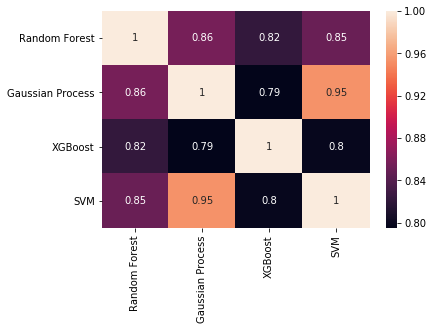

In [30]:
preds = pd.concat([pd.Series(test_preds_rf),pd.Series(test_preds_gauss),pd.Series(test_preds_xgb),pd.Series(test_preds_svm)], axis = 1)

preds.columns = ['Random Forest', 'Gaussian Process', 'XGBoost', 'SVM']
preds.corr()

import seaborn as sns

sns.heatmap(preds.corr(), xticklabels=preds.columns, yticklabels=preds.columns, annot=True)


In [31]:
from sklearn.ensemble import VotingClassifier
svm_model.set_params(probability = True)
vc_model = VotingClassifier([('rf',rf_model),('xgb',xgb_model),('gp',gp_model),('svm',svm_model)], voting = 'soft')


X_train = train_gp.drop(['Survived'], axis = 1)
y_train = train_gp['Survived']
X_test = test_gp.drop(['Survived'],axis = 1)

vc_model.fit(X_train, y_train)

preds_train = vc_model.predict(X_train)

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train, preds_train))
y_preds_test = vc_model.predict(X_test)

create_submission(test_gp,y_preds_test, "submission_vc_soft.csv")

/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[[515  33]
 [ 67 275]]


## Critique, questions and problems 

In this work, I did some feature analysis, feature engineering and tried a few different models. 

- I do introduce a bias by drawing from the classes' respective distributions in age. This might be questionable, and other methods might be more appropriate. For example, just filling in with the median, but I don't think that is the way to go either. 
- Upsampling is, to be honest, probably not completely needed here. The data set is already *quite* balanced, and introducing the bias through upsampling of people surviving might actually hurt the results. I did it first, but decided not to, which actually improved my scores. 
- Feature selection needs to be improved. Currently, I have 36 columns. While this is still ~20 times less than the number of training samples, many of these matrices are sparse. 
- How I choose my parameters for my gridsearch for the models can still be improved. I would love to receive feedback on the grid input parameters for the models. 
- Although I did remove some outliers, I am not sure as to how much these actually affect the models that I specifically chose to implement, apart from logistic regression, which is sensitive to outliers. 

So far, the RandomForest, the Gaussian Process and XGBoost have yielded the best scores. I think there might be some feature engineering left to do. 